# Fit SEIR model with genetic algorithm

## Setup

Import the database helper function and the genetic model

https://github.com/alessandropalla/CoViD-19-risk-analysis

In [4]:
# Get the working directory
import os
os.getcwd()

'C:\\Users\\Anoop Mishra'

In [5]:
# change the working directory
os.chdir('F:/CoViD-19-risk-analysis')
os.getcwd()

'F:\\CoViD-19-risk-analysis'

In [7]:
from db.utils import Database, to_numpy
from analysis.model import SEIRPopulation

Define a plot helper function.

In [8]:
from matplotlib import pyplot as plt
import matplotlib
from itertools import cycle
cycol = cycle('bgrcmk')

def plot(data, labels, log_scale=False, filename=None):
    fig = plt.figure(facecolor='w', figsize =(15,7))
    ax = fig.add_subplot(111)
    # ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
    for dd, label in zip(data, labels):
        ax.plot(range(len(dd)), dd, next(cycol), alpha=0.5, lw=2, label=label)
    
    ax.set_xlabel('Days since 100 infected')
    ax.set_ylabel('Number')
    
    
    max_t = max([len(dd) for dd in data])
#     ax.xaxis.set_ticks(range(max(t)), minor=True)
    ax.xaxis.set_ticks(range(0, max_t, 7), minor=False)
    ax.xaxis.set_tick_params(length=0)
    if log_scale:
      ax.set_yscale("log")
      locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=10)
      ax.yaxis.set_minor_locator(locmin)
      ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    ax.grid(True, which="both")
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    fig.show()
    if filename:
        plt.savefig(filename)
        logger.info(f"Plot saved to {filename}")
    return fig, ax

## Load the data

Load the data from the Johns Hopkins University <a href="https://github.com/CSSEGISandData/2019-nCoV">dataset</a>

Add/remove countries from the list below in order to build a model for them.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


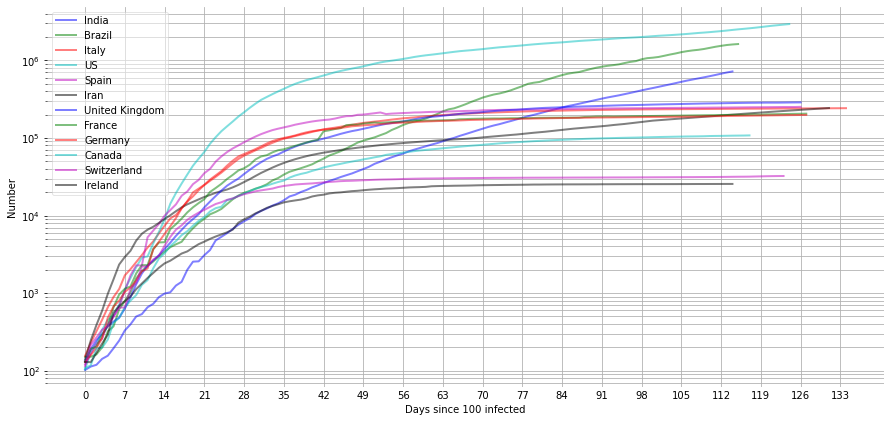

In [9]:
countries = ["India","Brazil","Italy", "US", "Spain", "Iran", "United Kingdom", "France", "Germany", "Canada", "Switzerland", "Ireland"]

data = {}
for country in countries:
    dates, confirmed = to_numpy(Database("confirmed").get_patients_by_country(country))
    data[country] = confirmed
    
samples = [data[country] for country in countries]
fig, ax = plot(samples, countries, log_scale=True)

The graph shows the number of cases vs time. The day zero is the one where more than 100 individuals infected were recorded.

## Training

Fit the country specific SEIR model with the data.

In [12]:
models = {} 

for country in countries:
    dates, confirmed = to_numpy(Database("confirmed").get_patients_by_country(country))
    population = SEIRPopulation(confirmed, "analysis/configurations/100_generations.yaml")
    population.generations = 20
    print(f"Train model for {country}          ")
    for idx, _ in population.train():
        print("".join(idx*["="] + (population.generations-idx)*["."]), end='\r')
    models[country] = population.best_models()[0]

Train model for India          
Train model for Brazil          
Train model for Italy          
Train model for US          
Train model for Spain          
Train model for Iran          
Train model for United Kingdom          
Train model for France          
Train model for Germany          
Train model for Canada          
Train model for Switzerland          
Train model for Ireland          


## Evaluate Models

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


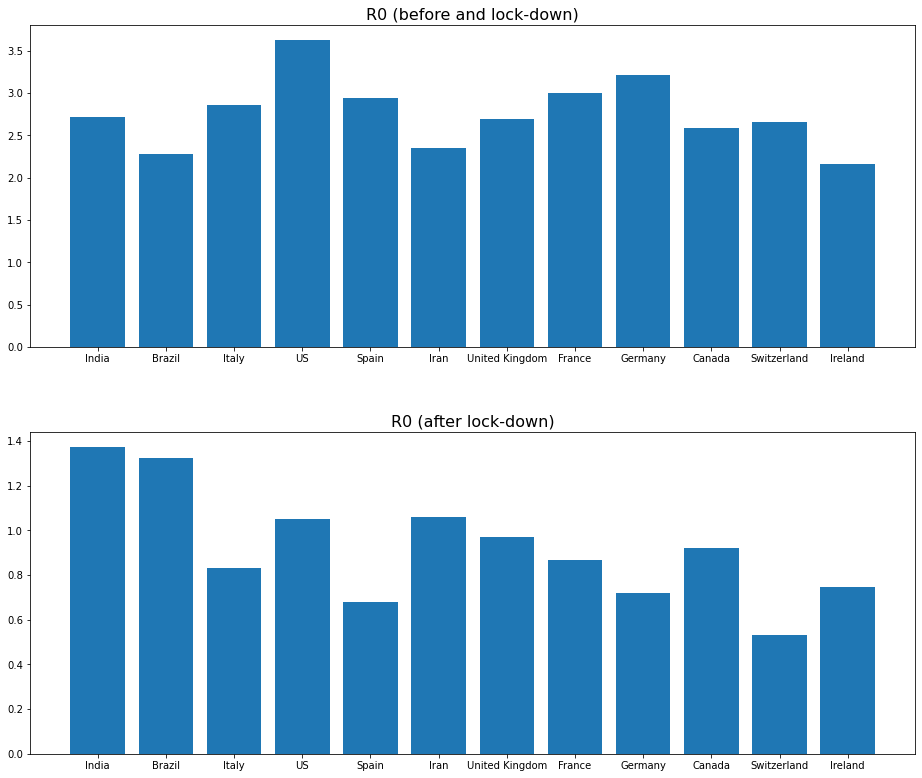

In [13]:
def get_parameter(label):
    return [[gene.value for gene in model.genes if gene.name == label][0] 
            for model in models.values()]

fig, axs = plt.subplots(2, 1, figsize=(14,12))

axs[0].set_title("R0 (before and lock-down)", fontsize=16)
axs[0].bar(range(len(countries)), get_parameter("R0"), label="R0")
axs[0].set_xticks(range(len(countries)))
axs[0].set_xticklabels(countries)

axs[1].set_title("R0 (after lock-down)", fontsize=16)
axs[1].bar(range(len(countries)), [eff*R0 for eff, R0 in zip(get_parameter("effectiveness"), get_parameter("R0"))], label="R0")
axs[1].set_xticks(range(len(countries)))
axs[1].set_xticklabels(countries)

fig.tight_layout(pad=5)
fig.show()

## Simulate in 10 days

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


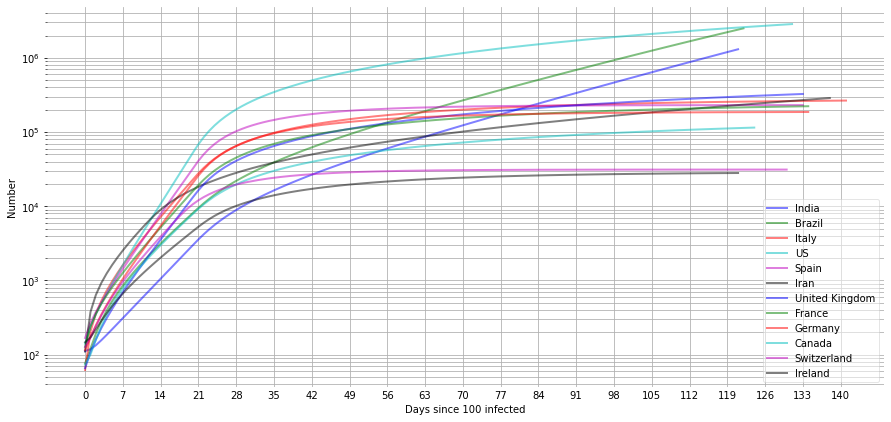

In [14]:
samples = [models[country].simulate(range(len(data[country]) + 7 ))[3] for country in countries]
fig, ax = plot(samples, countries, log_scale=True)